# Bayesian optimization with fixed features
In some contexts a variable/feature needs to be fixed during optimization. However, we
can leverage previous measurements near the fixed variable value to potentially
jump-start optimization using observed model covariances established by the GP kernel
. In this example, we start with a number of random observations in 2D input space
and then proceed with BO at a fixed value for one of the variables. This notebook
uses the 2D Rosenbrock test function as an example.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.resources.test_functions.rosenbrock import evaluate_rosenbrock,make_rosenbrock_vocs

# make rosenbrock function vocs in 2D
vocs = make_rosenbrock_vocs(2)

# define a fixed value for the BO generator
fixed_features = {"x0":-1.0}
generator = UpperConfidenceBoundGenerator(
    vocs=vocs, fixed_features=fixed_features
)
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_rosenbrock)

X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 0+untagged.1.g794a67b
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
  function_kwargs:
    dummy: 1
    label: y
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  fixed_features:
    x0: -1.0
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
 

## Generate some initial random samples in 2D space

In [2]:
X.random_evaluate(10)

,x0,x1,y,xopt_runtime,xopt_error
0,-1.259702,1.293165,13.731226,0.000012,False
1,1.085382,0.998910,3.216546,0.000004,False
2,1.244155,0.372514,138.218280,0.000003,False
3,0.083930,1.875227,349.849918,0.000003,False
4,0.682518,-0.066147,28.400816,0.000002,False
5,-1.562172,-1.336534,1433.074558,0.000002,False
6,0.804961,-0.508180,133.704513,0.000003,False
7,-0.697548,-0.960033,212.148663,0.000002,False
8,-0.618162,-0.672290,113.797434,0.000002,False
9,1.849120,1.291117,453.614502,0.000002,False


## Run BO steps with fixed features

In [3]:
for i in range(5):
    X.step()

In [4]:
X.data

,x0,x1,y,xopt_runtime,xopt_error
0,-1.259702,1.293165,13.731226,0.000012,False
1,1.085382,0.998910,3.216546,0.000004,False
2,1.244155,0.372514,138.218280,0.000003,False
3,0.083930,1.875227,349.849918,0.000003,False
4,0.682518,-0.066147,28.400816,0.000002,False
5,-1.562172,-1.336534,1433.074558,0.000002,False
6,0.804961,-0.508180,133.704513,0.000003,False
7,-0.697548,-0.960033,212.148663,0.000002,False
8,-0.618162,-0.672290,113.797434,0.000002,False
9,1.849120,1.291117,453.614502,0.000002,False


## Visualize model and evaluations
Note that for the BO samples, they all are on the line $x_0=-1$

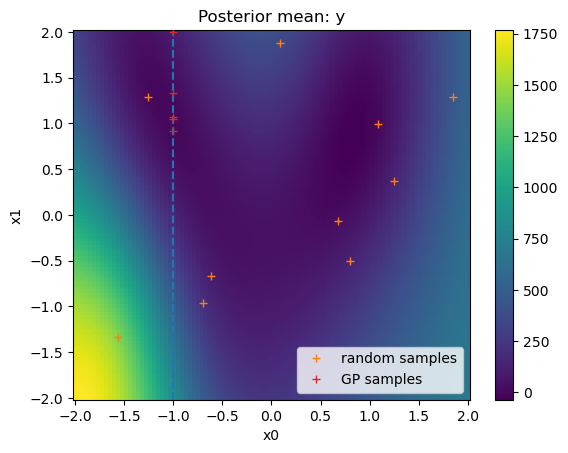

In [5]:
from matplotlib import pyplot as plt  # plot model predictions
import torch
data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(generator.data)

# create mesh
n = 100
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

xx,yy = xx.numpy(), yy.numpy()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x0", "x1"]].to_numpy()[:10].T, "+C1",
                label="random samples",
                zorder=10
                )
        ax.plot(*data[["x0", "x1"]].to_numpy()[10:].T, "+C3",
                label="GP samples",
                zorder=10)


        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n)
        )
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")
        ax.axvline(-1.0,ls="--")
        ax.set_xlabel("x0")
        ax.set_ylabel("x1")
        ax.legend()